In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 10.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
train = pd.read_csv('/content/train_spam.csv')
train.head(50)

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
5,spam,i am so greatful to mrs valerie dodson for hel...
6,ham,url url date not supplied government employees...
7,spam,welcome to jefferson pilot s gateway to wealth...
8,ham,looks like your ham corpus by and large has to...
9,ham,how are you with moneyas in to youmoney aint a...


Нужно предобработать данные

In [5]:
missing_values = train.isna().sum()
print(missing_values)
#Мало ли)))

text_type    0
text         0
dtype: int64


<Axes: xlabel='text_type', ylabel='count'>

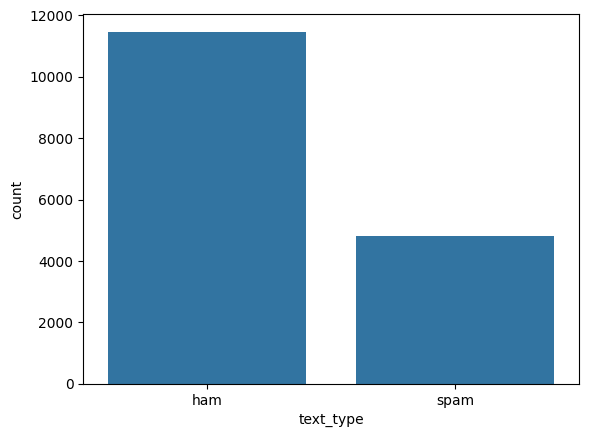

In [6]:
sns.countplot(data = train, x = train['text_type'])

Почистим текст, уберем всю пунктуацию и возможные двойные пробелы


In [7]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d', '', text)
    return text
train['tokens'] = [preprocess_text(i) for i in train['text']]

In [8]:
labels = {'ham': 0, 'spam': 1}
train['text_type'] = train['text_type'].map(labels)

Преобразовали таргет в числа и теперь векторизируем наш train

In [9]:
vectorizer = TfidfVectorizer(stop_words='english')
train_matrix = vectorizer.fit_transform(train['tokens'])

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train_matrix, train['text_type'], test_size=0.2, random_state=42)

На всякий зафиксирую random_state, shuffle нет смысла фиксировать, он по дефолту True

In [11]:
X_train.dtype

dtype('float64')

Теперь напишем функцию обучения, чтобы не захламлять код и не оставлять кучу мусора

In [12]:
def train_test(model, X_train, y_train, X_val, y_val):
  model.fit(X_train, y_train)
  predictions = model.predict_proba(X_val)[:, 1]
  roc_auc = roc_auc_score(y_val, predictions)
  return roc_auc

Попробуем базовые модели, не меняя параметров, ничего не трогая

In [18]:
model = RandomForestClassifier()
print("ROC AUC = ", train_test(model, X_train, y_train, X_val, y_val))

ROC AUC =  0.979351284597502


In [19]:
model = MultinomialNB()
print("ROC AUC = ", train_test(model, X_train, y_train, X_val, y_val))

ROC AUC =  0.9557585127192547


In [20]:
model = KNeighborsClassifier()
print("ROC AUC = ", train_test(model, X_train, y_train, X_val, y_val))

ROC AUC =  0.6797166996523258


In [22]:
model = SVC(probability = True)
print("ROC AUC = ", train_test(model, X_train, y_train, X_val, y_val))

ROC AUC =  0.9842201061224303


In [17]:
model = CatBoostClassifier(verbose = False)
print("ROC AUC = ", train_test(model, X_train, y_train, X_val, y_val))

ROC AUC =  0.9752644420738802


In [31]:
model = XGBClassifier(objective = 'binary:logistic')
print("ROC AUC = ", train_test(model, X_train, y_train, X_val, y_val))

ROC AUC =  0.7252592580645906


In [28]:
model = LGBMClassifier(verbose = -1)
print("ROC AUC = ", train_test(model, X_train, y_train, X_val, y_val))

ROC AUC =  0.9720584203286893


Лучше всего себя показали, CatBoost, LightGBM, SVC, RandomForest. Теперь проведем небольшой тест параметров именно для них. Обучается долго, поэтому небольшой GridSearch.

In [33]:
param_grid = {
    'iterations': [100, 500],
    'learning_rate': [0.01, 0.1],
    'depth': [5, 7, 9],
    'loss_function': ['CrossEntropy']
}
model = CatBoostClassifier(verbose=False)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'depth': 9, 'iterations': 500, 'learning_rate': 0.1, 'loss_function': 'CrossEntropy'}


In [31]:
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 7, 9],
    'objective': ['binary'],
    'metric': ['auc'],
    'verbose': [-1]
}

model = LGBMClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'metric': 'auc', 'n_estimators': 500, 'objective': 'binary', 'verbose': -1}


In [19]:
param_grid = {
    'C': [0.1, 0.5, 1, 2, 5, 10],
    'kernel': ['linear', 'rbf'],
}
model = SVC(probability=True)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 2, 'kernel': 'rbf'}


In [37]:
param_grid = {
    'n_estimators': [100, 500, 1000, 1500],
    'criterion' :['gini', 'entropy'],
}
model = RandomForestClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'entropy', 'n_estimators': 1000}


Теперь обучим с подобранными параметрами и выберем по итогу лучшую модель

In [22]:
model = CatBoostClassifier(depth = 9, iterations = 500, learning_rate = 0.1, loss_function = 'CrossEntropy', verbose = False)
print("ROC AUC = ", train_test(model, X_train, y_train, X_val, y_val))

ROC AUC =  0.9785080190863702


In [26]:
model = LGBMClassifier(learning_rate = 0.1, max_depth = 9, n_estimators = 500, objective = 'binary', verbose = -1)
print("ROC AUC = ", train_test(model, X_train, y_train, X_val, y_val))

ROC AUC =  0.976466901828688


In [45]:
model = SVC(probability = True, C = 2)
print("ROC AUC = ", train_test(model, X_train, y_train, X_val, y_val))

ROC AUC =  0.9855746301497372


In [34]:
model = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy')
print("ROC AUC = ", train_test(model, X_train, y_train, X_val, y_val))

ROC AUC =  0.9818398394569924


Итого, лучшая модель - SVC с параметров С = 2 . Теперь обработаем файл test_spam.csv и запишем результат в файл. Обработаем аналогично как было сделано для train.

In [70]:
test = pd.read_csv('/content/test_spam.csv')
test.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [71]:
missing_values = test.isna().sum()
print(missing_values)

text    0
dtype: int64


In [72]:
test['tokens'] = [preprocess_text(i) for i in test['text']]

In [73]:
vectorizer = TfidfVectorizer(stop_words='english')
train_final = vectorizer.fit(train['tokens'])
test_final = vectorizer.transform(test['tokens'])
test = test.drop(columns = 'text')
test = test.rename(columns={'tokens': 'text'})

In [75]:
model = SVC(probability = True, C = 2)
model.fit(X_train, y_train)
predicted_result = model.predict(test_final)
predicted_list = list(predicted_result)

In [76]:
test['score'] = predicted_list
test

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,0
1,original message from bitbitch magnesium net p...,0
2,java for managers vince durasoft who just taug...,0
3,there is a youtuber name saiman says,0
4,underpriced issue with high return on equity t...,1
...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,0
4066,baylor enron case study cindy yes i shall co a...,0
4067,boring as compared to tp,0
4068,hellogorgeous hows u my fone was on charge lst...,0


Запишем финальный результат в файл

In [77]:
test.to_csv('sample_submit.csv', index=False)

Ради интереса посмотрим на распределение ответов в столбце text_type. Выглядит неплохо

<Axes: xlabel='score', ylabel='count'>

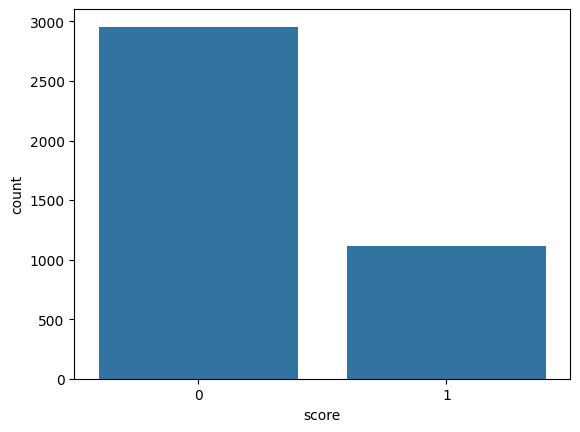

In [79]:
sns.countplot(data = test, x = test['score'])